#Batch Normalisation

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml("mnist_784",version=1)

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib as mpl
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os 
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR

Storing the MNSIT data into X and y Variables

In [ ]:
import numpy as np
X,y=mnist["data"],mnist["target"]
y=y.astype(int)
X=((X/255.)-.5)*2
print(X.shape,y.shape)
print(min(y),max(y))
print(type(X),type(y))
print(np.min(X), np.max(X))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


Defining a class hyperparam to store the values of learning rate, number of epochs,mini-batch size and momentum.

In [ ]:
# Define key hyperparameters
class hyperparam:
    
    lr = 0.05  # learning rate
    num_epochs = 50  # Number of epochs
    bs = 50  # Mini-batch size 
    moment = 0.9 # Momentum SGD 

###Splitting into train and test data

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #train_images, val_images, train_labels, val_labels

Separate into labels and training images and reshape the images

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state = 42)

for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]
    
    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]

print(X_train_strat.shape,y_train_strat.shape,X_dev_strat.shape,y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [ ]:
train_images = X_train_strat.reshape(X_train_strat.shape[0], 28, 28) #reshape the images to 54000,28,28 from 54000,784
val_images = X_dev_strat.reshape(X_dev_strat.shape[0], 28, 28)
test_images = X_test.reshape(X_test.shape[0], 28, 28)

Converting images to tensors and normalising them

In [ ]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(y_train_strat)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(y_dev_strat)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

Load images into the data generator

In [ ]:
train_loader = DataLoader(train_tensor, batch_size=50, num_workers=6, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=50, num_workers=6, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=50, num_workers=6, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Defining the CNN Model 

#####Batch Normalisation between the CNN layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), #Batch normalisation
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),        #128*7*7 is derived using the formulae w2=((w1-F+2*p)/S)+1 for the Conv2d and w2=((w1-F)/S)+1 for maxpooling
            nn.BatchNorm1d(128),            #where p=padding, s=stride, F= filter size, w1 and w2 number of nodes in that layer
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

Glorat Initialisation 

In [ ]:
def init_weights(m): 
  if type(m) == nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

In [ ]:
conv_model = Net()
conv_model.apply(init_weights) #Initialising the weights using the glorat Initialisation method
conv_model 

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3

###Defining the optimizer and loss functions

SGD Optimiser - 
params:- learning rate-0.05, momentum-0.9 
and using the Cross Entropy Loss Function

Learning Rate Schedular adjusting 10% every 10 epochs

torch.cuda to check if any gpu is available to use it. Google Collab GPU was used here to run the files.

In [ ]:
optimizer = torch.optim.SGD(params=conv_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.10) #learning rate scheduler
criterion = nn.CrossEntropyLoss() #cross entropy loss to calculate the loss between the predicted and the actual
if torch.cuda.is_available(): # To check if any gpu is available to run on
    print("GPU available")
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

GPU available


###Training the Model

In [ ]:
#Train the DNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    conv_model.train(True) 
    exp_lr_scheduler.step() #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            
            #Model computations
            out1 = conv_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
            #scheduler.step() 
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      conv_model.eval()

      for local_batch,local_labels in val_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=conv_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        #print(correction)
        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(val_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("Accuracy for ",epoch," epoch -","train_accuracy-",tr_accuracy," Validation_accuracy- ",dev_accuracy)



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Accuracy for  0  epoch - train_accuracy- 0.9706296296296296  Validation_accuracy-  0.9881666666666666
Accuracy for  1  epoch - train_accuracy- 0.9886296296296296  Validation_accuracy-  0.9883333333333333
Accuracy for  2  epoch - train_accuracy- 0.9918703703703704  Validation_accuracy-  0.9911666666666666
Accuracy for  3  epoch - train_accuracy- 0.9937592592592592  Validation_accuracy-  0.9901666666666666
Accuracy for  4  epoch - train_accuracy- 0.9952777777777778  Validation_accuracy-  0.99
Accuracy for  5  epoch - train_accuracy- 0.9959444444444444  Validation_accuracy-  0.9905
Accuracy for  6  epoch - train_accuracy- 0.9967962962962963  Validation_accuracy-  0.9921666666666666
Accuracy for  7  epoch - train_accuracy- 0.9969814814814815  Validation_accuracy-  0.9908333333333333
Accuracy for  8  epoch - train_accuracy- 0.9977777777777778  Validation_accuracy-  0.9916666666666667
Accuracy for  9  epoch - train_accuracy- 0.999  Validation_accuracy-  0.9928333333333333
Accuracy for  10  e

With Batch Normalisation the Train and Validation Accuracy is very high from the frist epoch itself. So performing batch normalisation between each of the CNN layers improves the accuracy and helps the model to converge quickly too.

###Plotting the Learning Curves - for the Test and the Validation Sets

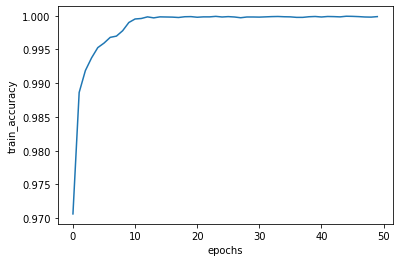

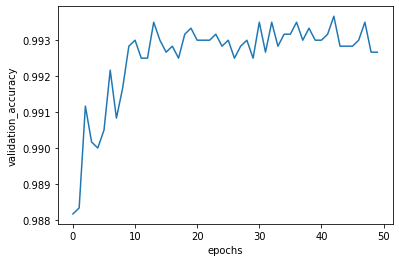

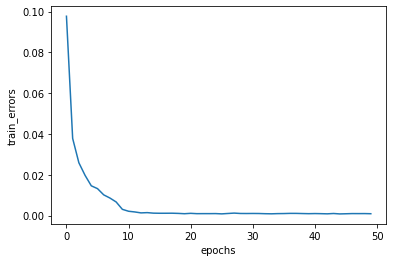

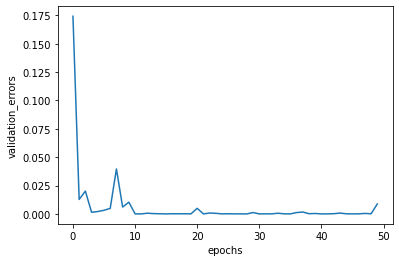

In [ ]:
plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

From the learning curves we can see that the errors for both the train and validation models is less from the first epoch itself.

###Test Set


In [ ]:
 def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicted Labels

In [ ]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


###Test Accuracy and the Confusion Matrix on the test Set


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
accuracy=accuracy_score(y_true,y_pred)
confusion_matrix=confusion_matrix(y_true, y_pred)
print("Test Accuracy - ",accuracy*100,"%")
print(" \nConfusion Matrix- ")
print(confusion_matrix)

Test Accuracy -  99.42 %
 
Confusion Matrix- 
[[ 978    1    0    0    0    0    0    1    0    0]
 [   0 1133    0    0    1    0    0    1    0    0]
 [   1    0 1027    0    0    0    0    4    0    0]
 [   0    0    1 1007    0    1    0    0    1    0]
 [   0    0    0    0  978    0    1    0    0    3]
 [   0    0    0    6    0  885    1    0    0    0]
 [   3    3    0    0    1    1  948    0    2    0]
 [   0    3    2    0    0    0    0 1022    0    1]
 [   1    0    2    0    0    0    0    0  970    1]
 [   0    0    1    0    5    2    0    5    2  994]]


The baseline SGD model with batch normalisation has a test accuracy of 99.42% which is slighlty higher than the baseline SGD model.


The model converges quickly too when compared to the Baseline SGD which makes it a better choice to perform Batch Normalisation between each convolution hidden layer.